In [1]:
# First, we install actual versions of TF and Keras
!pip install --upgrade -q tensorflow
!pip install -q keras

In [54]:
# Importing necessary libs
import pandas as pd
import numpy as np
import hashlib
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras import models, layers, callbacks, metrics
from keras.utils import np_utils


from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

In [55]:
# Let's read our data and take a look at it
# We have 84 features with mixed dtypes and the Class target variable
data = pd.read_csv('Keylogger_Detection.csv').drop(columns=['Unnamed: 0'])
len_data = len(data)
data

C:\Users\Lenovo\anaconda32021\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (48,56) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Class
0,10.42.0.211-52.6.25.230-34451-443-6,10.42.0.211,34451.0,52.6.25.230,443.0,6.0,04/08/2017 05:12:36,12140931.0,9.0,6.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,172.217.3.99-10.42.0.151-443-53892-6,10.42.0.151,53892.0,172.217.3.99,443.0,6.0,04/08/2017 07:55:51,418882.0,102.0,203.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,172.217.3.98-10.42.0.151-443-50750-6,172.217.3.98,443.0,10.42.0.151,50750.0,6.0,04/08/2017 08:48:19,45.0,2.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,10.42.0.211-10.42.0.1-23025-53-17,10.42.0.211,23025.0,10.42.0.1,53.0,17.0,04/08/2017 05:54:10,541699.0,1.0,1.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,10.42.0.211-123.129.244.226-52602-443-6,10.42.0.211,52602.0,123.129.244.226,443.0,6.0,04/08/2017 08:44:25,7310795.0,3.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523612,10.42.0.151-106.39.169.66-52373-80-6,10.42.0.151,52373.0,106.39.169.66,80.0,6.0,30/06/2017 01:22:05,589453.0,5.0,3.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Keylogger
523613,10.42.0.211-10.42.0.1-2522-53-17,10.42.0.211,2522.0,10.42.0.1,53.0,17.0,04/08/2017 12:40:03,216310.0,1.0,1.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
523614,220.243.219.55-10.42.0.211-80-60995-6,10.42.0.211,60995.0,220.243.219.55,80.0,6.0,04/08/2017 09:39:08,5215688.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
523615,172.217.12.138-10.42.0.211-443-52724-6,10.42.0.211,52724.0,172.217.12.138,443.0,6.0,04/08/2017 01:41:22,223370.0,16.0,11.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [56]:
# Let's check our data for missing values and fill NAs with mode if missing values exist
for col in data.drop(columns=['Class']).columns:
  if data[col].isna().any():
    print(f"Column {col} contains missing values")
    data[col] = data[col].fillna(data[col].mode().iloc[0])

Column Flow ID contains missing values
Column  Flow IAT Mean contains missing values
Column  Flow IAT Std contains missing values
Column  Flow IAT Max contains missing values
Column  Flow IAT Min contains missing values
Column Fwd IAT Total contains missing values
Column  Fwd IAT Mean contains missing values
Column  Fwd IAT Std contains missing values
Column  Fwd IAT Max contains missing values
Column  Fwd IAT Min contains missing values
Column Bwd IAT Total contains missing values
Column  Bwd IAT Mean contains missing values
Column  Bwd IAT Std contains missing values
Column  Bwd IAT Max contains missing values
Column  Bwd IAT Min contains missing values
Column Fwd PSH Flags contains missing values
Column  Bwd PSH Flags contains missing values
Column  Fwd URG Flags contains missing values
Column  Bwd URG Flags contains missing values
Column  Fwd Header Length contains missing values
Column  Bwd Header Length contains missing values
Column Fwd Packets/s contains missing values
Column  

In [57]:
# We have many columns with Object dtype; let's apply one-hot encoding
# (if the number of unique values is relatively small)
# or hashing if there are many uniques
cols_to_drop = []

for col in data.drop(columns=['Class']).columns:
  if data[col].dtype == 'object':
    print(f'Column {col} has {data[col].nunique()} values among {len_data}')

    if data[col].nunique() < 25:
      print(f'One-hot encoding of {col}')
      one_hot_cols = pd.get_dummies(data[col])
      for ohc in one_hot_cols.columns:
        data[col + '_' + str(ohc)] = one_hot_cols[ohc]
    else:
      print(f'Hashing of {col}')
      data[col + '_hash'] = data[col].apply(lambda row: int(hashlib.sha1((col + "_" + str(row)).encode('utf-8')).hexdigest(), 16) % len_data)

    cols_to_drop.append(col)

Column Flow ID has 91920 values among 523617
Hashing of Flow ID
Column  Source IP has 1815 values among 523617
Hashing of  Source IP
Column  Destination IP has 3189 values among 523617
Hashing of  Destination IP
Column  Timestamp has 40542 values among 523617
Hashing of  Timestamp
Column  Packet Length Std has 39346 values among 523617
Hashing of  Packet Length Std
Column  CWE Flag Count has 4 values among 523617
One-hot encoding of  CWE Flag Count


In [58]:
# Dropping non-hashed versions of columns from previous step
data = data.drop(columns=cols_to_drop)

In [59]:
# The target variable (Class) has 6 unique string values,
# let's represent them with numerical labels
class_nums = {}
i = 0
for cl in data.Class.unique():
    class_nums[cl] = i
    i += 1

data['Class_num'] = [class_nums[cl] for cl in data.Class.values]
data = data.drop(columns=['Class'])
data

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,Idle Min,Flow ID_hash,Source IP_hash,Destination IP_hash,Timestamp_hash,Packet Length Std_hash,CWE Flag Count_0.0,CWE Flag Count_0,CWE Flag Count_SCAREWARE,Class_num
0,34451.0,443.0,6.0,12140931.0,9.0,6.0,334.0,3664.0,208.0,0.0,...,0.0,371382,4753,233965,188586,257797,0,0,0,0
1,53892.0,443.0,6.0,418882.0,102.0,203.0,829.0,279509.0,517.0,0.0,...,0.0,410694,123846,495601,230960,422555,0,0,0,0
2,443.0,50750.0,6.0,45.0,2.0,0.0,55.0,0.0,55.0,0.0,...,0.0,180866,32038,518422,487211,792,0,0,0,0
3,23025.0,53.0,17.0,541699.0,1.0,1.0,39.0,225.0,39.0,39.0,...,0.0,387785,4753,84728,102836,227165,0,0,0,0
4,52602.0,443.0,6.0,7310795.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,32450,4753,366778,508071,176265,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523612,52373.0,80.0,6.0,589453.0,5.0,3.0,2924.0,121.0,1460.0,0.0,...,0.0,223006,123846,180742,71664,452709,0,0,0,1
523613,2522.0,53.0,17.0,216310.0,1.0,1.0,37.0,74.0,37.0,37.0,...,0.0,354748,4753,84728,242794,319394,0,0,0,0
523614,60995.0,80.0,6.0,5215688.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,382024,4753,135571,113606,176265,0,0,0,0
523615,52724.0,443.0,6.0,223370.0,16.0,11.0,11275.0,1187.0,1368.0,0.0,...,0.0,260704,4753,234524,506576,295288,0,0,0,0


In [60]:
# We have quite many features, so there may be highly correlated ones;
# having highly correlated features won't help our model, so let's drop them
# We drop the features that have correlation coefficient between 0.9 and 1
# We don't include 1 as every feature has CC=1 with itself
# Code idea is taken from
# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
corr = data.drop(columns=["Class_num"]).corr()
corr_top = corr.abs().unstack().sort_values(kind='quicksort')
corr_top = corr_top[corr_top > 0.9][corr_top < 1]

cols_to_drop = [corr_top.index[i][0] for i in range(0, len(corr_top), 2)]
print(f"Highly correlated features: {cols_to_drop}")
data = data.drop(columns=cols_to_drop)

data

Highly correlated features: [' Bwd Packet Length Mean', ' Avg Bwd Segment Size', ' Min Packet Length', 'Fwd Packets/s', ' Packet Length Variance', ' Average Packet Size', ' Average Packet Size', 'Fwd IAT Total', ' Fwd Packet Length Max', ' Active Max', ' Flow Duration', ' Idle Min', ' Flow IAT Mean', ' Fwd IAT Min', ' Bwd IAT Max', ' Bwd Packet Length Std', ' Active Min', ' Bwd Packet Length Std', 'Init_Win_bytes_forward', ' Min Packet Length', ' Protocol', ' Idle Max', ' Idle Min', 'Total Length of Fwd Packets', ' Subflow Fwd Bytes', ' Max Packet Length', ' Packet Length Mean', ' Bwd Packets/s', ' Bwd PSH Flags', ' Bwd URG Flags', ' Bwd Packets/s', ' Subflow Bwd Bytes', ' Total Length of Bwd Packets', ' Total Length of Bwd Packets', ' Subflow Bwd Bytes', ' Max Packet Length', 'Fwd PSH Flags', 'Fwd PSH Flags', 'Fwd PSH Flags', 'Fwd PSH Flags', ' Protocol', ' Total Fwd Packets', ' Fwd Header Length', ' Fwd Header Length.1', ' Avg Fwd Segment Size', ' Bwd URG Flags', ' Bwd PSH Flags', ' 

,Source Port,Destination Port,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Flow Packets/s,Flow IAT Std,...,Idle Std,Flow ID_hash,Source IP_hash,Destination IP_hash,Timestamp_hash,Packet Length Std_hash,CWE Flag Count_0.0,CWE Flag Count_0,CWE Flag Count_SCAREWARE,Class_num
0,34451.0,443.0,0.0,37.111111,76.440245,1448.0,0.0,3.292993e+02,1.235490,3.179603e+06,...,0.0,371382,4753,233965,188586,257797,0,0,0,0
1,53892.0,443.0,0.0,8.127451,57.270709,1418.0,0.0,6.692529e+05,728.128685,6.067904e+03,...,0.0,410694,123846,495601,230960,422555,0,0,0,0
2,443.0,50750.0,0.0,27.500000,38.890873,0.0,0.0,1.222222e+06,44444.444444,0.000000e+00,...,0.0,180866,32038,518422,487211,792,0,0,0,0
3,23025.0,53.0,39.0,39.000000,0.000000,225.0,225.0,4.873555e+02,3.692087,0.000000e+00,...,0.0,387785,4753,84728,102836,227165,0,0,0,0
4,52602.0,443.0,0.0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.410352,5.126208e+06,...,0.0,32450,4753,366778,508071,176265,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523612,52373.0,80.0,0.0,584.800000,798.946306,121.0,0.0,5.165806e+03,13.571905,1.251750e+05,...,0.0,223006,123846,180742,71664,452709,0,0,0,1
523613,2522.0,53.0,37.0,37.000000,0.000000,74.0,74.0,5.131524e+02,9.245990,0.000000e+00,...,0.0,354748,4753,84728,242794,319394,0,0,0,0
523614,60995.0,80.0,0.0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.383459,0.000000e+00,...,0.0,382024,4753,135571,113606,176265,0,0,0,0
523615,52724.0,443.0,0.0,704.687500,687.150320,586.0,0.0,5.579084e+04,120.875677,1.436014e+04,...,0.0,260704,4753,234524,506576,295288,0,0,0,0


In [61]:
# Neural network fits better on data with small range, so let's scale it
ss = StandardScaler()
data_scaled = pd.DataFrame(columns=data.drop(columns=['Class_num']).columns,data=ss.fit_transform(data.drop(columns=['Class_num']), data.Class_num))
data_scaled['Class_num'] = data.Class_num
data_scaled

,Source Port,Destination Port,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Flow Packets/s,Flow IAT Std,...,Idle Std,Flow ID_hash,Source IP_hash,Destination IP_hash,Timestamp_hash,Packet Length Std_hash,CWE Flag Count_0.0,CWE Flag Count_0,CWE Flag Count_SCAREWARE,Class_num
0,-0.210468,-0.368578,-0.212203,-0.182887,-0.018077,1.992640,-0.356094,-0.100220,-0.140149,0.112635,...,-0.121634,0.714752,-0.806277,-0.026111,-0.482692,0.345380,-0.052787,-0.214913,-0.002394,0
1,0.828401,-0.368578,-0.212203,-0.417931,-0.144807,1.938685,-0.356094,0.606939,-0.120963,-0.384509,...,-0.121634,0.974543,-0.091533,1.649509,-0.204585,1.717001,-0.052787,-0.214913,-0.002394,0
2,-2.027754,2.839532,-0.212203,-0.260828,-0.266317,-0.611576,-0.356094,1.191516,1.032915,-0.385460,...,-0.121634,-0.544263,-0.642525,1.795664,1.477229,-1.794203,-0.052787,-0.214913,-0.002394,0
3,-0.821039,-0.393449,0.522915,-0.167569,-0.523426,-0.206915,2.998913,-0.100052,-0.140084,-0.385460,...,-0.121634,0.823150,-0.806277,-0.981883,-1.045483,0.090367,-0.052787,-0.214913,-0.002394,0
4,0.759467,-0.368578,-0.212203,-0.483840,-0.523426,-0.611576,-0.356094,-0.100568,-0.140171,0.417576,...,-0.121634,-1.525063,-0.806277,0.824476,1.614136,-0.333379,-0.052787,-0.214913,-0.002394,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523612,0.747230,-0.391727,-0.212203,4.258613,4.758439,-0.393958,-0.356094,-0.095107,-0.139823,-0.365851,...,-0.121634,-0.265783,-0.091533,-0.366972,-1.250069,1.968035,-0.052787,-0.214913,-0.002394,1
523613,-1.916658,-0.393449,0.485216,-0.183788,-0.523426,-0.478487,0.747330,-0.100025,-0.139937,-0.385460,...,-0.121634,0.604827,-0.806277,-0.981883,-0.126917,0.858179,-0.052787,-0.214913,-0.002394,0
523614,1.207964,-0.391727,-0.212203,-0.483840,-0.523426,-0.611576,-0.356094,-0.100568,-0.140171,-0.385460,...,-0.121634,0.785079,-0.806277,-0.656265,-0.974797,-0.333379,-0.052787,-0.214913,-0.002394,0
523615,0.765986,-0.368578,-0.212203,5.230844,4.019352,0.442340,-0.356094,-0.041588,-0.136991,-0.383210,...,-0.121634,-0.016658,-0.806277,-0.022531,1.604324,0.657495,-0.052787,-0.214913,-0.002394,0


In [62]:
# Separating the dataset into train, test and validation sets at the ratio of (70%/15%/15%)
X_train, X_test, Y_train, Y_test = train_test_split(data_scaled.drop(columns=['Class_num']), data_scaled.Class_num,
                                                   random_state=42, stratify=data_scaled.Class_num, train_size=0.7)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, random_state=42, stratify=Y_test, train_size=0.5)

In [63]:
# Let's check the target distribution;
# it's easy to notice that the '0' class samples prevail,
# so it's reasonable to assign weigths to classes to compensate
# the imbalance
data_scaled['Class_num'].value_counts()

0    308813
1    214804
Name: Class_num, dtype: int64

In [64]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=Y_train.unique(),
                                                 y=Y_train.values)

In [65]:
# Before fitting, we have to one-hot encode the target vectors as we have multiclass problem
Y_train = np_utils.to_categorical(Y_train, data_scaled.Class_num.nunique())
Y_test = np_utils.to_categorical(Y_test, data_scaled.Class_num.nunique())
Y_val = np_utils.to_categorical(Y_val, data_scaled.Class_num.nunique())

In [66]:
# Let's construct our simple DNN with two hidden layers
clf = models.Sequential()
clf.add(layers.Dense(64, activation='relu', input_dim=data_scaled.shape[1]-1))
clf.add(layers.Dense(64, activation='relu'))
clf.add(layers.Dense(64, activation='relu'))
clf.add(layers.Dense(data_scaled.Class_num.nunique(), activation='softmax'))

clf.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                3328      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 130       
Total params: 11,778
Trainable params: 11,778
Non-trainable params: 0
_________________________________________________________________


In [67]:
# The target metric is CategoricalAccuracy; it's accuracy
# for multiclass data with one-hot encoded labels
clf.compile(optimizer='adam',
 loss='categorical_crossentropy',
 metrics=[metrics.CategoricalAccuracy()])

In [68]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
keras = tf.keras


# buat panggilan balik penghentian awal
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

# Simpan riwayat model menjadi variabel
history = clf.fit(X_train, Y_train, 
                  epochs=100, validation_data=(X_val, Y_val),
                  callbacks=[callbacks.EarlyStopping(monitor='val_categorical_accuracy',
                                   patience=5,
                                   verbose=1,
                                   restore_best_weights=True,
                                   mode='max')])

Epoch 1/100
11455/11455 [==============================] - 12s 1ms/step - loss: 0.6250 - categorical_accuracy: 0.6385 - val_loss: 0.6130 - val_categorical_accuracy: 0.6484
Epoch 2/100
11455/11455 [==============================] - 12s 1ms/step - loss: 0.6037 - categorical_accuracy: 0.6599 - val_loss: 0.5978 - val_categorical_accuracy: 0.6634
Epoch 3/100
11455/11455 [==============================] - 11s 990us/step - loss: 0.5930 - categorical_accuracy: 0.6684 - val_loss: 0.5946 - val_categorical_accuracy: 0.6655
Epoch 4/100
11455/11455 [==============================] - 11s 1ms/step - loss: 0.5849 - categorical_accuracy: 0.6749 - val_loss: 0.5838 - val_categorical_accuracy: 0.6785
Epoch 5/100
11455/11455 [==============================] - 11s 997us/step - loss: 0.5777 - categorical_accuracy: 0.6817 - val_loss: 0.5853 - val_categorical_accuracy: 0.6736
Epoch 6/100
11455/11455 [==============================] - 12s 1ms/step - loss: 0.5720 - categorical_accuracy: 0.6864 - val_loss: 0.5768

11455/11455 [==============================] - 12s 1ms/step - loss: 0.5024 - categorical_accuracy: 0.7395 - val_loss: 0.5292 - val_categorical_accuracy: 0.7251
Epoch 49/100
11455/11455 [==============================] - 12s 1ms/step - loss: 0.5020 - categorical_accuracy: 0.7400 - val_loss: 0.5273 - val_categorical_accuracy: 0.7232
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping


In [71]:
# Finally evaluating our model on test data
clf.evaluate(X_test, Y_test)

df =pd.DataFrame.from_dict(history.history)
print(df.mean())

2455/2455 [==============================] - 2s 707us/step - loss: 0.5255 - categorical_accuracy: 0.7281
loss                        0.533425
categorical_accuracy        0.716361
val_loss                    0.548968
val_categorical_accuracy    0.706139
dtype: float64


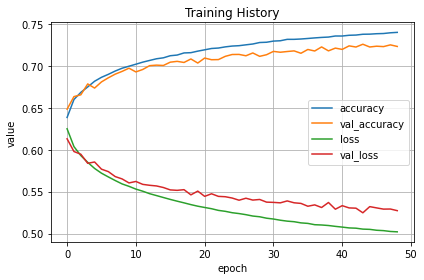

In [72]:
# Plot model training history
def plot_history():
    plt.plot(history.history['categorical_accuracy'],label='accuracy')
    plt.plot(history.history['val_categorical_accuracy'],label='val_accuracy')
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.legend()
    plt.title('Training History')
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.tight_layout()
    plt.grid(True)
    plt.savefig('keylogger3.jpg')
    plt.show()

plot_history()

In [42]:
#data.to_csv('file_name.csv', index=False)


In [99]:
data_scaled.to_csv('uji.csv', index=False)

In [104]:
# make class predictions with the model ##
Xnew = loadtxt('Keylogger_Detection_Test1.csv', delimiter=',') #, dtype='str')
#ynew = clf.predict(Xnew)

ynew = clf.predict(Xnew)
ynew = np.round(ynew).astype(int)

for i in range(len(Xnew)):
    print("X=%s, Predicted=%d" % (Xnew[i], ynew[i]))

ValueError: could not convert string to float: ''

In [101]:
# make class predictions with the model ##
Xnew = loadtxt('Keylogger_Detection_Test1.csv', delimiter=',') #, dtype='str')
ynew = clf.predict(Xnew)

for i in range(len(Xnew)):
    print("X=%s, Predicted=%d" % (Xnew[i], ynew[i]))

ValueError: could not convert string to float: ''

In [102]:
Xnew

array([[ 3.44510000e+04,  4.43000000e+02,  0.00000000e+00,
         3.71111111e+01,  7.64402454e+01,  1.44800000e+03,
         0.00000000e+00,  3.29299293e+02,  1.23549010e+00,
         3.17960278e+06,  1.19141640e+07,  1.90000000e+01,
         1.51761638e+06,  4.20092354e+06,  1.19141640e+07,
         1.61697000e+05,  3.23394000e+04,  4.67056244e+04,
         1.90000000e+01,  2.00000000e+02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  9.00000000e+00,  6.00000000e+00,
         1.19000000e+02,  2.00000000e+00,  3.20000000e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  3.71382000e+05,  4.75300000e+03,
         2.33965000e+05,  1.88586000e+05,  2.57797000e+05,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [103]:
ynew

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [113]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[13,  0,  0],
       [ 0, 10,  6],
       [ 0,  0,  9]], dtype=int64)

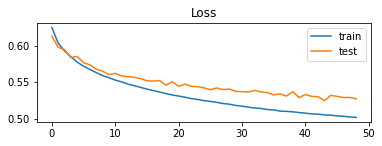

In [121]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

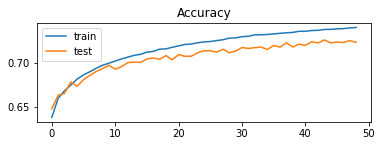

In [119]:
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='test')
plt.legend()
plt.show()

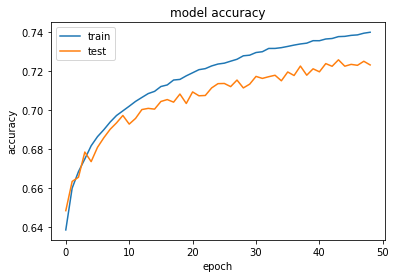

In [123]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


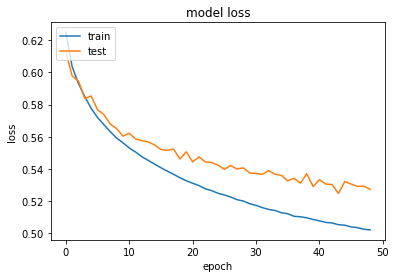

In [124]:
# summarize history for loss
# We can see that the model has comparable performance on both train
# and validation datasets (labeled test
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()